In [1]:
import Pkg

# Pkg.add("MathOptInterface")
# Pkg.add("Ipopt")
# Pkg.add("FiniteDiff")
# Pkg.add("ForwardDiff")
# Pkg.add("Convex")
# Pkg.add("ECOS")
# Pkg.add("Plots")
# Pkg.add("JLD2")
# Pkg.add("MeshCat")
# Pkg.add("StaticArrays")
# Pkg.add("Interpolations")


Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf
using Interpolations

  Activating environment at `c:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

# Armed Thrower

### Problem statement: 

Let we have a armed robot with link length $l_1, l_2$ and mass $m_1, m_2$. It also have a ball attached to its end with mass $m_b$. 

# Dynamics Constraints

State:
$$ \mathbf x  = \begin{bmatrix}\theta_1& \theta_2&  \dot \theta_1&\dot \theta_2& p_x& p_y& \dot p_x& \dot p_y\end{bmatrix}^T$$

Arm Dynamics Constraint:
$$\dot{\mathbf x}[1:4] = f(\mathbf x[1:4], u) = \begin{cases}
    \begin{bmatrix}\dot \theta & M_1(\theta)^{-1}(u - C_1(\theta, \dot \theta) - G_1(\theta))\end{bmatrix} & t < T_1 \\
    \begin{bmatrix}\dot \theta & M_2(\theta)^{-1}(u - C_2(\theta, \dot \theta) - G_2(\theta))\end{bmatrix} & t \ge T_1
\end{cases}$$

In which $M_1, C_1, G_1$ represent the dynamics of the arm with the ball attached, and $M_2, C_2, G_2$ represent after the ball is detached.  

Ball Dynamics Constraint:
- when $t < T_1$, it is attached to the arm and thus fully determined by $\theta, \dot \theta$.
$$
    \mathbf x [5:8] = g(\mathbf x) =  \begin{bmatrix}
        l_1 \cos(\theta_1) + l_2 \cos(\theta_1 + \theta_2) \\
        l_1 \sin(\theta_1) + l_2 \sin(\theta_1 + \theta_2) \\
        -l_1 \sin(\theta_1)\dot \theta_1 - l_2 \sin(\theta_1 + \theta_2) (\dot \theta_1 + \dot \theta_2)\\
        l_1 \cos(\theta_1)\dot \theta_1 + l_2 \cos(\theta_1 + \theta_2) (\dot \theta_1 + \dot \theta_2)\\
    \end{bmatrix}
$$

- when $t > T_1$, the ball is no longer attached to the arm and only affected by gravity. 
$$
    \dot{\mathbf x} [5:8] = f_g(\mathbf x[5:8]) = \begin{bmatrix}
        \dot p_x \\
        \dot p_y \\
        0\\
        -g
    \end{bmatrix}
$$


In [3]:
# ======================================== arm dynamics functions ========================================
function arm_M(params::NamedTuple, mb::Real, theta::Vector)
    m1 = params.m1  # Mass of link 1
    m2 = params.m2 + mb # Mass of link 2 + mass of ball
    l1 = params.l1  # Length of link 1
    l2 = params.l2  # Length of link 2

    # Joint angles
    q1, q2 = theta

    # Elements of the mass matrix M
    M11 = (m1 + m2) * l1^2 + m2 * l2^2 + 2 * m2 * l1 * l2 * cos(q2)
    M12 = m2 * l2^2 + m2 * l1 * l2 * cos(q2)
    M21 = M12  # Symmetry in the mass matrix
    M22 = m2 * l2^2

    # Return the mass matrix as a 2x2 matrix
    M = [M11 M12; M21 M22]
    return M
end

function arm_C(params::NamedTuple, mb::Real, theta::Vector, dtheta::Vector)
    m1 = params.m1  # Mass of link 1
    m2 = params.m2 + mb # Mass of link 2 + mass of ball
    l1 = params.l1  # Length of link 1
    l2 = params.l2  # Length of link 2

    # Joint angles
    q1, q2 = theta

    # Joint velocities
    dq1, dq2 = dtheta

    C1 = 0
    C2 = -m2 * l1 * l2 * sin(q2) 
    C3 = -m2 * l1 * l2 * sin(q2)
    C4 = m2 * l1 * l2 * sin(q2)
    C5 = 0
    C6 = 0

    C = [C1 C2 C3; C4 C5 C6]

    return C * [dq1^2; dq1*dq2; dq2^2]
end

function arm_G(params::NamedTuple, mb::Real, theta::Vector)
    m1 = params.m1  # Mass of link 1
    m2 = params.m2 + mb # Mass of link 2 + mass of ball
    l1 = params.l1  # Length of link 1
    l2 = params.l2  # Length of link 2
    g = params.g  # Gravity

    # Joint angles
    q1, q2 = theta

    G1 = -g * ((m1 + m2) * l1 * cos(q1) + m2 * l2 * cos(q1 + q2))
    G2 = -g * m2 * l2 * cos(q1 + q2)

    return [G1; G2]
end

function arm_dynamics(params::NamedTuple, xa::Vector, u::Vector,mb::Real)
    theta = xa[1:2]
    dtheta = xa[3:4]
    
    M = arm_M(params, mb, theta)
    C = arm_C(params, mb, theta, dtheta)
    G = arm_G(params, mb, theta)

    q1, q2 = theta
    dq1, dq2 = dtheta

    # Compute the acceleration
    ddtheta = M \ (u - C - G) #  

    return [dq1; dq2; ddtheta]
end

function arm_dynamics_with_ball(params::NamedTuple, xa::Vector, u::Vector)
    mb = params.mb
    return arm_dynamics(params, xa, u, mb)
end

function arm_dynamics_without_ball(params::NamedTuple, xa::Vector, u::Vector)
    return arm_dynamics(params, xa, u, 0)
end

# ======================================== ball dynamics constraint during acceleration ========================================

function ball_constraint_at_release(params::NamedTuple, xa::Vector)
    l1 = params.model.l1
    l2 = params.model.l2

    q1, q2 = xa[1:2]
    dq1, dq2 = xa[3:4]

    xb1 = l1 * cos(q1) + l2 * cos(q1 + q2)
    xb2 = l1 * sin(q1) + l2 * sin(q1 + q2)
    xb3 = -l1 * sin(q1) * dq1 - l2 * sin(q1 + q2) * (dq1 + dq2)
    xb4 = l1 * cos(q1) * dq1 + l2 * cos(q1 + q2) * (dq1 + dq2)

    return [xb1; xb2; xb3; xb4]
end

# ======================================== ball freeflight ========================================
function ball_freeflight(params::NamedTuple, xb::Vector, dt)
    # free-body motion can be explicitly integrated
    g = params.model.g
    return [xb[1] + xb[3]*dt; xb[2] + xb[4]*dt - 0.5 * g * dt^2 ; xb[3]; xb[4] - g*dt]
end

# integrator for the arm dynamics
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end  

rk4 (generic function with 1 method)

## Optimization problem formulation



   $$ 

% cost function

   \begin{align} 
    \min_{x_{1:N_1 + N_2},u_{1:N_1}, \Delta t_1, \Delta t_2} \quad & J(x_{1:N_1 + N_2},u_{1:N_1}) =  \frac{1}{2} \sum_{i=1}^{N_1} u_i^T R u_i * \Delta t_1 + \frac{1}{2} \sum_{i=N_1+1}^{N_2} u_i^T R u_i * \Delta t_2& \\ 

% initial condition
 
 \text{st} \quad &  x_1 = x_{ic} & \tag{1}\\

% hit the target at the end

 \quad & x_{N_1 + N_2}[1] = goal_x & \tag{2}\\
 \quad & x_{N_1 + N_2}[3] = goal_y & \tag{3}\\
 
% dynamics constraint during the accelerate phase

&x_{k+1} = f_1(x_k,u_k, \Delta t_1) & \text{for } k =1, \cdots, \mathbf{N_1} \tag{4}\\

% dynamics constraint during the drop phase

&x_{k+1} = f_2(x_k,u_k, \Delta t_2) & \text{for } k =N_1 + 1, \cdots, N_1 + N_2 \tag{5}\\

% range for times

&\Delta t_1 \in [0.01, 0.5]  \tag{6}\\
&T_h \in [0.1, 10]  \tag{7}\\

 \end{align}$$


In [4]:
# feel free to solve this problem however you like, below is a template for a 
# good way to start. 

function create_idx(nxa, nxb, nu,N1,N2)
    # create idx for indexing convenience
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    # and stacked dynamics constraints of size nx are 
    # c[idx.c[i]] = <dynamics constraint at time step i>
    #
    # feel free to use/not use this 
    
    # our Z vector is [xa0, u0, xa1, u1, …, xaN1-1, uN1-1, xaN1, xb1, ..., xbN1, xbF, dt1, T2]
    nz = (N1 + N2 - 1) * (nu + nxa) + nxa # arm state
    nz += 1 * nxb # ball state during acceleration
    nz += 1 * nxb # ball state during free fall
    nz += 1 # dt1 and T2

    xa = vcat([(i - 1) * (nxa + nu) .+ (1 : nxa) for i = 1:(N1 + N2)])
    u = [(i - 1) * (nxa + nu) .+ ((nxa + 1):(nxa + nu)) for i = 1:(N1 + N2 - 1)]

    offset = (N1 + N2 - 1) * (nxa + nu) + nxa

    xb = vcat([((i - 1) * nxb + offset) .+ (1 : nxb) for i = 1:1]) # ball state at final acceleration
    offset += 1 * nxb

    xbF = offset .+ (1 : nxb)  # ball state during free fall

    T2 = nz

    # # create index for constraints
    nc_arm = (N1 + N2 - 1) * nxa # arm dynamics constraint
    # nc += N1 * nxb # ball dynamics constraint during acceleration
    # nc += 1 * nxb # ball dynamics constraint during free fall

    c_arm = [(i - 1) * nxa .+ (1 : nxa) for i = 1:(N1 + N2 - 1)]

    return (nxa=nxa,nxb=nxb,nu=nu,N1=N1,N2=N2,nz=nz,xa=xa,u=u,xb=xb,xbF=xbF,  T2 = T2, nc_arm=nc_arm, c_arm=c_arm)
end


function thrower_cost(params::NamedTuple, Z::Vector)::Real
    # cost function 
    idx, N1, N2 = params.idx, params.N1, params.N2
    dt1 = params.dt1
    dt2 = params.dt2
    R = params.R
    
    J = 0 
    for i = 1 : N1
        xi = Z[idx.xa[i]]
        ui = Z[idx.u[i]]
        J += 0.5 * ui'*R*ui * dt1
    end

    for i = N1+1 : N1 + N2 - 1
        xi = Z[idx.xa[i]]
        ui = Z[idx.u[i]]
        J += 0.5 * ui'*R*ui * dt2
    end
            
    return J # + 10 * Z[idx.T] # FIXME: 
end

function arm_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N1, N2 = params.idx, params.N1, params.N2

    # time steps
    dt1 = params.dt1
    dt2 = params.dt2
    T2 = Z[idx.T2]

    model = params.model 
        
    # TODO: input walker dynamics constraints (constraints 3-6 in the opti problem)
    c = zeros(eltype(Z), idx.nc_arm)

    for i = 1 : N1
        xi = Z[idx.xa[i]]
        ui = Z[idx.u[i]]
        xi1 = Z[idx.xa[i+1]]
        c[idx.c_arm[i]] = xi1 - rk4(model, arm_dynamics_with_ball, xi, ui, dt1)
    end

    for i = N1+1 : N1 + N2 - 1
        xi = Z[idx.xa[i]]
        ui = Z[idx.u[i]]
        xi1 = Z[idx.xa[i+1]]
        c[idx.c_arm[i]] = xi1 - rk4(model, arm_dynamics_without_ball, xi, ui, dt2)
    end

    return c 
end

function ball_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N1, N2 = params.idx, params.N1, params.N2

    # constraint between ball and arm at the point of release
    xaN1 = Z[idx.xa[N1]]
    xb1 = Z[idx.xb[1]]

    C1 = ball_constraint_at_release(params, xaN1) - xb1 # constraint at the point of release

    xbF = Z[idx.xbF]
    T2 = Z[idx.T2]

    # free fall dynamics
    C2 = ball_freeflight(params, xb1, T2) - xbF
    
    return [C1; C2]
end

function thrower_target_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N1, N2 = params.idx, params.N1, params.N2
    target = params.target
        
    # create c in a ForwardDiff friendly way (check HW0)
    # c = zeros(eltype(Z), N)
    
    terminal_constraint_x = Z[idx.xbF[1]] - target[1]
    terminal_constraint_y = Z[idx.xbF[2]] - target[2]
    
    return [
        terminal_constraint_x;
        terminal_constraint_y
    ]
end
    
function thrower_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    
    arm_initial_condition_constraint = Z[params.idx.xa[1]] - params.arm_init

    arm_dynamics_constraint = arm_dynamics_constraints(params, Z)
    ball_dynamics_constraint = ball_dynamics_constraints(params, Z)
    target_constraint = thrower_target_constraints(params, Z)

    return [arm_initial_condition_constraint; arm_dynamics_constraint; ball_dynamics_constraint; target_constraint]
end

function thrower_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    # idx, N, dt = params.idx, params.N, params.dt
    # M1, M2 = params.M1, params.M2 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), 1)
    
    # TODO: add the length constraints shown in constraints (9-10)
    # there are 2*N constraints here 
    # for i = 1:N
    #     rk_b = Z[idx.x[i]][1:2]
    #     rk_1 = Z[idx.x[i]][3:4]
    #     rk_2 = Z[idx.x[i]][5:6]

    #     c[2 * i - 1] = (rk_b - rk_1)' * (rk_b - rk_1)
    #     c[2 * i] = (rk_b - rk_2)' * (rk_b - rk_2)
    # end

    return c
end

thrower_inequality_constraint (generic function with 1 method)

In [5]:
# problem size and time 
nxa = 4
nxb = 4
nu = 2
N1 = 20
N2 = 20

dt1 = 0.05
dt2 = 0.05

# physics parameters
m1 = 0.5
m2 = 0.5
l1 = 0.8
l2 = 0.5

mb = 0.1
g = 9.81

# cost
R = 0.01 * I(nu)

# target and initial conditions
target = [3, -1]
arm_init = [0, 0, 0, 0] # theta, thetadot


model = (
    m1=m1,
    m2=m2,
    l1=l1,
    l2=l2,
    g=g,
    mb=mb
)

xic = [0, 0, 0, 0]

# create indexing utilities 
idx = create_idx(nxa,nxb,nu,N1, N2)

# put everything useful in params 
params = (
    model = model, 
    nxa = nxa,
    nxb = nxb,
    nu = nu,
    idx = idx,
    N1 = N1,
    N2 = N2,
    target = target,
    arm_init = arm_init,
    R = R,
    dt2 = dt2,
    dt1=dt1
)

(model = (m1 = 0.5, m2 = 0.5, l1 = 0.8, l2 = 0.5, g = 9.81, mb = 0.1), nxa = 4, nxb = 4, nu = 2, idx = (nxa = 4, nxb = 4, nu = 2, N1 = 20, N2 = 20, nz = 247, xa = UnitRange{Int64}[1:4, 7:10, 13:16, 19:22, 25:28, 31:34, 37:40, 43:46, 49:52, 55:58  …  181:184, 187:190, 193:196, 199:202, 205:208, 211:214, 217:220, 223:226, 229:232, 235:238], u = UnitRange{Int64}[5:6, 11:12, 17:18, 23:24, 29:30, 35:36, 41:42, 47:48, 53:54, 59:60  …  179:180, 185:186, 191:192, 197:198, 203:204, 209:210, 215:216, 221:222, 227:228, 233:234], xb = UnitRange{Int64}[239:242], xbF = 243:246, T2 = 247, nc_arm = 156, c_arm = UnitRange{Int64}[1:4, 5:8, 9:12, 13:16, 17:20, 21:24, 25:28, 29:32, 33:36, 37:40  …  117:120, 121:124, 125:128, 129:132, 133:136, 137:140, 141:144, 145:148, 149:152, 153:156]), N1 = 20, N2 = 20, target = [3, -1], arm_init = [0, 0, 0, 0], R = [0.01 0.0; 0.0 0.01], dt2 = 0.05, dt1 = 0.05)

In [103]:

# TODO: primal bounds (constraint 11)
x_l =  -Inf*ones(idx.nz) # update this 
x_u =  Inf*ones(idx.nz) # update this 

# add some bounds to the time steps
# x_l[idx.dt1] = 0.01
# x_u[idx.dt1] = 1.0

x_l[idx.T2] = 1
x_u[idx.T2] = 10


# TODO: inequality constraint bounds (there are no inequality constraints in this problem for now)
c_l =  -Inf*ones(1) 
c_u =  Inf*ones(1)

# TODO: initialize z0 with the reference Xref, Uref 
z0 = zeros(idx.nz) 
# for k = 1 : N - 1
#     z0[idx.x[k]] = Xref[k]
#     z0[idx.u[k]] = Uref[k]
# end
# z0[idx.x[N]] = Xref[N]

# adding a little noise to the initial guess is a good idea 
z0 = z0 + (1e-6)*randn(idx.nz)

# some initial guess for the time steps
# z0[idx.dt1] = 0.03
z0[idx.T2] = 1

diff_type = :finite

Z = fmincon(thrower_cost,thrower_equality_constraint,thrower_inequality_constraint,
            x_l,x_u,c_l,c_u,z0,params, diff_type;
            tol = 1e-5, c_tol = 1e-5, max_iters = 10_000, verbose = true)

# # pull the X and U solutions out of Z 
Xa = [Z[idx.xa[i]] for i = 1:N1 + N2]
Xb = [Z[idx.xb[i]] for i = 1:1]
XbF = Z[idx.xbF]
dt1 = params.dt1
T2 = Z[idx.T2]
U = [Z[idx.u[i]] for i = 1:N1 + N2 - 1]


---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :finite (FiniteDiff.jl)---
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    41990
Number of nonzeros in inequality constraint Jacobian.:      247
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      247
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:      170
Total number of inequality constraints.......

39-element Vector{Vector{Float64}}:
 [2.5416629584143213, -4.682103762011195]
 [2.103156378581041, -3.9400297411855267]
 [1.593107953375314, -2.8489364506428427]
 [1.1205358203897415, -1.9123257074798683]
 [0.6181398903088428, -1.0754627279917632]
 [0.036704351500164746, -0.3554555376667496]
 [-0.6716458855877212, 0.22037389021262455]
 [-1.5130171908296925, 0.6203224768538949]
 [-2.411647892496054, 0.870196097173662]
 [-3.2408758127036124, 1.054343960100159]
 ⋮
 [-0.002479130219697561, -0.005513951303979189]
 [-0.001486811989123609, -0.004523471903969476]
 [-0.0006806786370231911, -0.003743291244580928]
 [-0.0003185985531026502, -0.0031325159858972807]
 [-0.00019380007616826727, -0.00262920635150716]
 [0.00015331747399378425, -0.002070853965493013]
 [-3.047397426045632e-6, -0.0014477729881843132]
 [-0.00028035185636654335, 0.0010269973163441507]
 [-0.00013290789189681149, 0.00032122487446365996]

In [106]:
# simulation of the system

function interp_multi(xp, yp, x)
    interp = LinearInterpolation(xp, yp, extrapolation_bc=Flat())
    interpolated_values = [interp(t_) for t_ in x]
    return interpolated_values
end

function zoh_interpolate_single(x, t, query_t)
    # x: array of data points
    # t: array of times corresponding to data points
    # query_t: the time point at which to interpolate the data

    # Find the right interval in 't' for 'query_t'
    for i in 1:length(t)-1
        if t[i] <= query_t < t[i+1]
            return x[i]
        end
    end

    # If 'query_t' is beyond the last time point, return the last data point
    return x[end]
end

function zoh_interpolate(x, t, query_t_list)
    return [zoh_interpolate_single(x, t, query_t) for query_t in query_t_list]
end

inter_ts = 0.01
# 1. interpolate the control inputs in time
T1 = dt1 * N1
T2_arm = dt2 * N2
T2_ball = T2

max_time = max(T1 + T2_arm, T1 + T2_ball)

number_of_points = ceil(Int, max_time / inter_ts)
t = (0:number_of_points-1) .* inter_ts

inter_ts = t[2] - t[1]

U_ts =  vcat(dt1 .* ((1:N1) .- 1), T1 .+ dt2 .* ((1:N2 - 1).- 1))
U_interp = zoh_interpolate(U,U_ts, t)


num_arm_steps = sum(t .< T1)
num_release_steps = sum(t .>= T1)

# ======================================== simulate the ARM ========================================

# drive the arm with the control before ball release
Xa_sim = [zeros(nxa) for i = 1:num_arm_steps + num_release_steps]
Xa_sim[1] = arm_init

for i = 1:num_arm_steps
    Xa_sim[i + 1] = rk4(model, arm_dynamics_with_ball, Xa_sim[i], U_interp[i], inter_ts)
end

# drive the arm without the ball after the release
for i = num_arm_steps+1:num_arm_steps + num_release_steps - 1
    Xa_sim[i + 1] = rk4(model, arm_dynamics_without_ball, Xa_sim[i], U_interp[i], inter_ts)
end

# ======================================== simulate the BALL ========================================
Xb_sim = [zeros(nxb) for i = 1:num_arm_steps + num_release_steps]

for i = 1:num_arm_steps
    Xb_sim[i] = ball_constraint_at_release(params, Xa_sim[i])
end

for i = num_arm_steps:num_arm_steps + num_release_steps - 1
    Xb_sim[i + 1] = ball_freeflight(params, Xb_sim[i], inter_ts)
end

┌ Info: Saved animation to c:\Users\yuche\OneDrive\Documents\0CMU\academic\courses\16-745\PreciseThrowControl\trajectory_animation.gif
└ @ Plots C:\Users\yuche\.julia\packages\Plots\Pe7wF\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\yuche\\OneDrive\\Documents\\0CMU\\academic\\courses\\16-745\\PreciseThrowControl\\trajectory_animation.gif")
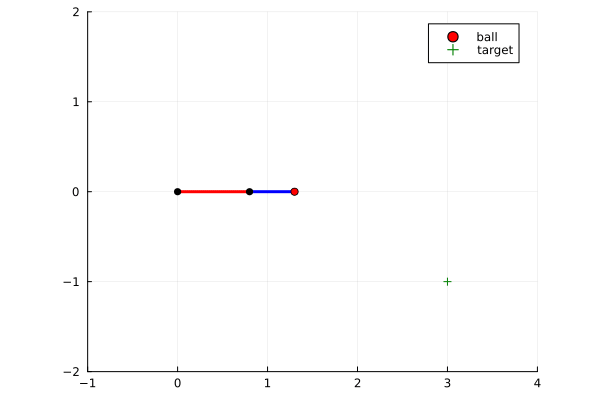

In [108]:
# interpolate the trajectory for animation
T1 = dt1 * N1
T2_arm = dt2 * N2
T2_ball = T2

max_time = max(T1 + T2_arm, T1 + T2_ball)

number_of_points = ceil(Int, max_time / inter_ts)
t = range(0, stop=max_time, length=number_of_points)

# interpolate arm
Xa_ts =  vcat(dt1 .* (1:N1), T1 .+ dt2 .* (1:N2))
Xa_interp = Xa_sim # interp_multi(Xa_ts, Xa, t)

# calculate the ball position
Xb_interp = Xb_sim # [zeros(nxb) for i = 1:length(t)]
# Xb_interp[t .<= T1] = [ball_constraint_at_release(params, Xa_interp[i]) for i = 1:length(t[t .<= T1])]

# idx_offset = length(t[t .<= T1])

# Xb_interp[t .> T1] = [ball_freeflight(params, Xb[1], t[i + idx_offset] - T1) for i = 1:length(t[t .> T1])]


# animate the results!
function plot_arm(x)
    xp1 = [
        model.l1 * cos(x[1]),
        model.l1 * sin(x[1])
    ]   

    xp2 = [
        xp1[1] + model.l2 * cos(x[1] + x[2]),
        xp1[2] + model.l2 * sin(x[1] + x[2])
    ]

    plot([0, xp1[1]], [0, xp1[2]], color="red", lw=3, label="")
    plot!([xp1[1], xp2[1]], [xp1[2], xp2[2]], color="blue", lw=3, label="")

    # plot the links
    scatter!([0, xp1[1], xp2[1]], [0, xp1[2], xp2[2]], color="black", label="", aspect_ratio=:equal, xlim=(-1, 4), ylim=(-2, 2))
    # print(xp1)
end

anim = @animate for i = 1:length(t)
    xa = Xa_interp[i]
    xb = Xb_interp[i]

    plot_arm(xa)
    scatter!([xb[1]], [xb[2]], color="red", label="ball")

    # plot target
    p = scatter!([target[1]], [target[2]], color="green", marker=:cross, label="target")

    savefig(p, "gif_throw/$(i).png")
end

# Save the animation
gif(anim, "trajectory_animation.gif", fps = 1.0 / inter_ts)


In [ ]:
# TVLQR for the arm



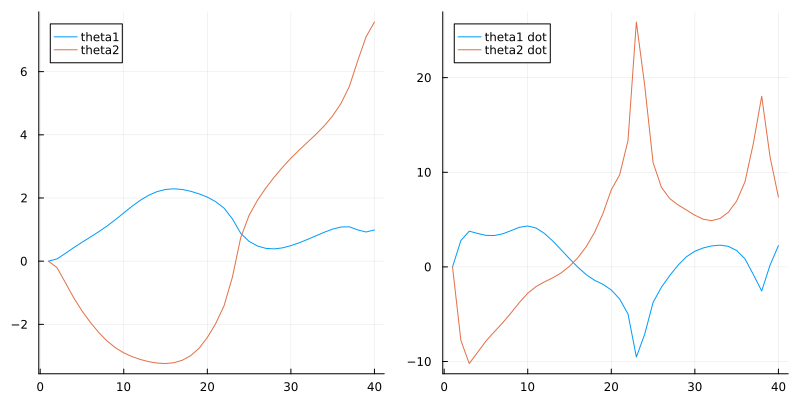

In [19]:
using Plots

# plot the arm's joint position, and joint Velocity
plot([Xa[i][1] for i = 1:N1 + N2], label="theta1")
plot_pos = plot!([Xa[i][2] for i = 1:N1 + N2], label="theta2")

# plot the Velocity in new figure


plot([Xa[i][3] for i = 1:N1 + N2], label="theta1 dot")
plot_vel = plot!([Xa[i][4] for i = 1:N1 + N2], label="theta2 dot")

p = plot(plot_pos, plot_vel, size=(800, 400))
# savefig(p, "throw_control.png")

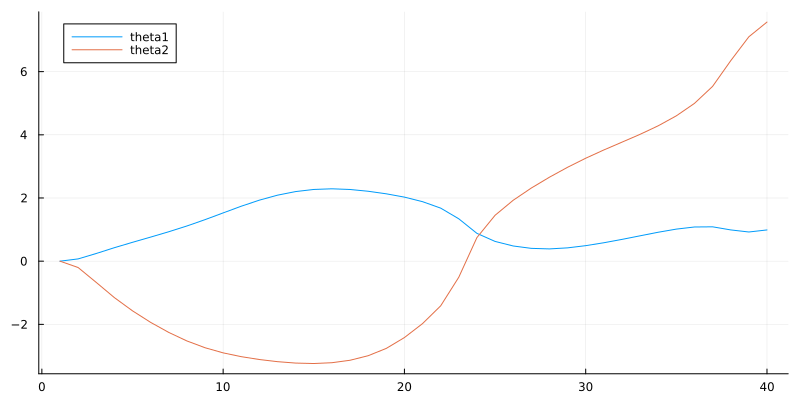

In [27]:
# plot the arm's joint position, and joint Velocity


plot([Xa[i][1] for i = 1:N1 + N2], label="theta1")
plot_pos = plot!([Xa[i][2] for i = 1:N1 + N2], label="theta2")

p = plot(plot_pos, size=(800, 400))
# savefig(p, "throw_control.png")

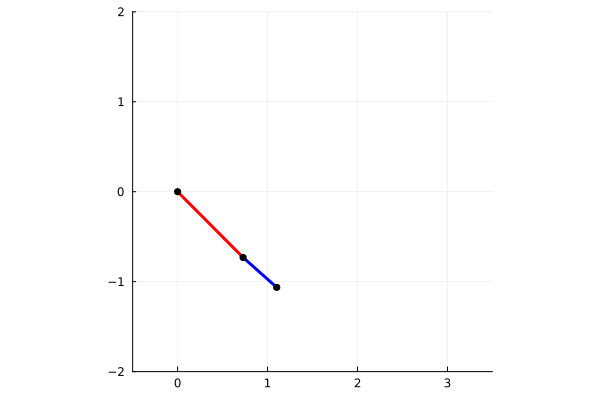

In [11]:
# make a animation for the solution

# plot the arm for one time Step given xa
x = Xa[4]



function plot_arm(x)
    xp1 = [
        model.l1 * cos(x[1]),
        model.l1 * sin(x[2])
    ]   

    xp2 = [
        xp1[1] + model.l2 * cos(x[1] + x[2]),
        xp1[2] + model.l2 * sin(x[1] + x[2])
    ]

    plot([0, xp1[1]], [0, xp1[2]], color="red", lw=3, label="")
    plot!([xp1[1], xp2[1]], [xp1[2], xp2[2]], color="blue", lw=3, label="", aspect_ratio=:equal, xlim=(-0.5, 3.5), ylim=(-2, 2))

    # plot the links
    scatter!([0, xp1[1], xp2[1]], [0, xp1[2], xp2[2]], color="black", label="")
end


plot_arm(x)
# make axis equal



In [12]:
using Plots


idx_x = 1:(N1)
idx_u = 1:(N1)

# Extracting X and U based on provided indexing scheme
# Adjust according to your actual idx.x and idx.u logic
pos = [[x[1], x[3]] for x in X]  # Positions x, y
vel = [[x[2], x[4]] for x in X]  # Velocities x, y
U = U  # Example control inputs, replace with your actual data extraction

# Plot Trajectory (Position x vs. Position y)
p1 = plot([x[1] for x in pos], [x[2] for x in pos], label="Trajectory (x vs. y)", title="Trajectory", xlabel="Position x", ylabel="Position y", aspect_ratio=:equal)

# Plot Velocities Over Time
p2 = plot(title="Velocity Over Time", xlabel="Time Step")
plot!(p2, [v[1] for v in vel], label="Velocity x")
plot!(p2, [v[2] for v in vel], label="Velocity y")

# # Plot Control Input U Over Time
p3 = plot(idx_u, [u[1] for u in U], label="Control Input U", title="Control Input U Over Time", xlabel="Time Step", ylabel="U")

# Display the plots
display(plot(p1, p2, p3, layout=(3, 1), size=(600, 900)))



UndefVarError: UndefVarError: X not defined

In [13]:
# Animate Trajectory
dt1 = Z[idx.T1] / N1
dt2 = Z[idx.T2] / N2

dt1_array = dt1 * ones(N1)
dt2_array = dt2 * ones(N2)

dt = vcat(dt1_array, dt2_array)
t = cumsum(dt)

anim = @animate for i = 1:length(X)
    plot([x[1] for x in X[1:i]], [x[3] for x in X[1:i]], limit=:auto, label="Trajectory up to step $i", title="Trajectory Animation", xlabel="Position x", ylabel="Position y", aspect_ratio=:equal, linewidth=3)

    if i <= N1
        # holding
        plot!([0, target[1]], [0, 0], label="Holding", color="red", linestyle=:dash)
    else
        # throwing
        plot!([0, target[1]], [0, 0], label="Throwing", color="green", linestyle=:dash)
    end

    scatter!([X[i][1]], [X[i][3]], marker=:star, color="red", label="Object")
    p1 = scatter!([target[1]], [target[2]], marker=:cross, color="red", label="Target")

    plot(t, title="Time", xlabel="simulation step", ylabel="Time (s)", label="time")
    p2 = scatter!([i], [t[i]], marker=:cross, color="red", label="Current Time")

    # concat plots
    plot(p1, p2, layout=(1, 2), size=(1000, 500))
end

# Save the animation
gif(anim, "trajectory_animation.gif", fps = 5)

ErrorException: type NamedTuple has no field T1